In [31]:
import rdkit
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import seaborn
from chembl_webresource_client.new_client import new_client

In [91]:
import os

folders = ["data/raw" , "data/processed" , "notebooks"]

for folder in folders:
    os.makedirs(folder, exist_ok = True)
with open("requirements.txt" , "w") as f:
    f.write("rdkit\npandas\nnumpy\nmatplotlib\nseaborn\nxgboost\nchembl_webresource_client\nscikit-learn\njoblib")

In [11]:
# Define target (EGFR)
target = new_client.target
egfr_targets = target.filter(target_components__accession="P00533")
egfr_targets_df = pd.DataFrame(egfr_targets)

egfr_targets_df.head()

,cross_references,organism,pref_name,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Homo sapiens,Epidermal growth factor receptor erbB1,False,CHEMBL203,"[{'accession': 'P00533', 'component_descriptio...",SINGLE PROTEIN,9606
1,[],Homo sapiens,Epidermal growth factor receptor and ErbB2 (HE...,False,CHEMBL2111431,"[{'accession': 'P04626', 'component_descriptio...",PROTEIN FAMILY,9606
2,[],Homo sapiens,Epidermal growth factor receptor,False,CHEMBL2363049,"[{'accession': 'P04626', 'component_descriptio...",PROTEIN FAMILY,9606
3,[],Homo sapiens,MER intracellular domain/EGFR extracellular do...,False,CHEMBL3137284,"[{'accession': 'P00533', 'component_descriptio...",CHIMERIC PROTEIN,9606
4,[],Homo sapiens,Protein cereblon/Epidermal growth factor receptor,False,CHEMBL4523680,"[{'accession': 'P00533', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606


In [13]:
activity = new_client.activity
res = activity.filter(target_chembl_id="CHEMBL203").filter(standard_type="IC50")

df = pd.DataFrame(res)
df.head()

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,32260,[],CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,None,None,BAO_0000190,...,Homo sapiens,Epidermal growth factor receptor erbB1,9606,None,None,IC50,uM,UO_0000065,None,0.041
1,None,None,32263,[],CHEMBL621151,Inhibition of autophosphorylation of human epi...,F,None,None,BAO_0000190,...,Homo sapiens,Epidermal growth factor receptor erbB1,9606,None,None,IC50,uM,UO_0000065,None,0.3
2,None,None,32265,[],CHEMBL615325,Inhibition of ligand-induced proliferation in ...,F,None,None,BAO_0000190,...,Homo sapiens,Epidermal growth factor receptor erbB1,9606,None,None,IC50,uM,UO_0000065,None,7.82
3,None,None,32267,[],CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,None,None,BAO_0000190,...,Homo sapiens,Epidermal growth factor receptor erbB1,9606,None,None,IC50,uM,UO_0000065,None,0.17
4,None,None,32270,[],CHEMBL621151,Inhibition of autophosphorylation of human epi...,F,None,None,BAO_0000190,...,Homo sapiens,Epidermal growth factor receptor erbB1,9606,None,None,IC50,uM,UO_0000065,None,0.04


In [21]:
df.to_csv("data/raw/egfr_raw.csv", index=False)

In [23]:
df = pd.read_csv("data/raw/egfr_raw.csv")
print("Original shape:", df.shape)
df.head()

df = df[df['standard_type'] == 'IC50']
print("After filtering IC50:", df.shape)

Original shape: (18105, 46)
After filtering IC50: (18105, 46)


In [25]:
df = df[df['standard_value'].notna()]
df = df[df['canonical_smiles'].notna()]
print("After dropping NaNs:", df.shape)

After dropping NaNs: (16711, 46)


In [27]:
df = df[pd.to_numeric(df['standard_value'], errors='coerce').notnull()]
df['standard_value'] = df['standard_value'].astype(float)
print("After converting standard_value to float:", df.shape)

After converting standard_value to float: (16711, 46)


In [35]:
df['pIC50'] = -np.log10(df['standard_value'] * 1e-9)

df = df[(df['pIC50'] > 3) & (df['pIC50'] < 12)]
print("After filtering invalid pIC50:", df.shape)


After filtering invalid pIC50: (16644, 47)


In [37]:
df['activity_class'] = df['pIC50'].apply(lambda x: 'active' if x >= 6 else 'inactive')
df['activity_label'] = df['activity_class'].map({'active': 1, 'inactive': 0})
df[['pIC50', 'activity_class', 'activity_label']].head()

,pIC50,activity_class,activity_label
0,7.387216,active,1
1,6.522879,active,1
2,5.106793,inactive,0
3,6.769551,active,1
4,7.397940,active,1


In [39]:
df.to_csv("data/processed/egfr_cleaned.csv", index=False)

In [41]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import Crippen

In [45]:
df = pd.read_csv("data/processed/egfr_cleaned.csv", low_memory=False)
print(df.shape)

(16644, 49)


In [47]:
def calc_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    descriptors = {
        'MolWt': Descriptors.MolWt(mol),
        'LogP': Crippen.MolLogP(mol),
        'NumHDonors': Lipinski.NumHDonors(mol),
        'NumHAcceptors': Lipinski.NumHAcceptors(mol),
        'TPSA': Descriptors.TPSA(mol),
        'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
        'RingCount': Chem.rdMolDescriptors.CalcNumRings(mol)
    }
    return descriptors

In [49]:
descriptor_data = df['canonical_smiles'].apply(calc_descriptors)
descriptor_df = pd.DataFrame(descriptor_data.tolist())
print(descriptor_df.head())

     MolWt     LogP  NumHDonors  NumHAcceptors    TPSA  NumRotatableBonds  \
0  383.814  4.45034           3              4   82.70                  3   
1  383.814  4.45034           3              4   82.70                  3   
2  383.814  4.45034           3              4   82.70                  3   
3  482.903  3.61432           3              6  112.24                  4   
4  482.903  3.61432           3              6  112.24                  4   

   RingCount  
0          4  
1          4  
2          4  
3          5  
4          5  


In [50]:
final_df = pd.concat([descriptor_df, df[['activity_label']].reset_index(drop=True)], axis=1)
print(final_df.head())

     MolWt     LogP  NumHDonors  NumHAcceptors    TPSA  NumRotatableBonds  \
0  383.814  4.45034           3              4   82.70                  3   
1  383.814  4.45034           3              4   82.70                  3   
2  383.814  4.45034           3              4   82.70                  3   
3  482.903  3.61432           3              6  112.24                  4   
4  482.903  3.61432           3              6  112.24                  4   

   RingCount  activity_label  
0          4               1  
1          4               1  
2          4               0  
3          5               1  
4          5               1  


In [53]:
final_df = final_df.dropna()
print("Final shape:", final_df.shape)

Final shape: (16644, 8)


In [55]:
final_df.to_csv("data/processed/egfr_features.csv", index=False)

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
df = pd.read_csv("data/processed/egfr_features.csv")
df.head()

,MolWt,LogP,NumHDonors,NumHAcceptors,TPSA,NumRotatableBonds,RingCount,activity_label
0,383.814,4.45034,3,4,82.70,3,4,1
1,383.814,4.45034,3,4,82.70,3,4,1
2,383.814,4.45034,3,4,82.70,3,4,0
3,482.903,3.61432,3,6,112.24,4,5,1
4,482.903,3.61432,3,6,112.24,4,5,1


In [61]:
X = df.drop("activity_label", axis=1)
y = df["activity_label"]

In [63]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

In [65]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [67]:
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8215680384499849

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.62      0.68      1040
           1       0.84      0.91      0.88      2289

    accuracy                           0.82      3329
   macro avg       0.80      0.77      0.78      3329
weighted avg       0.82      0.82      0.82      3329



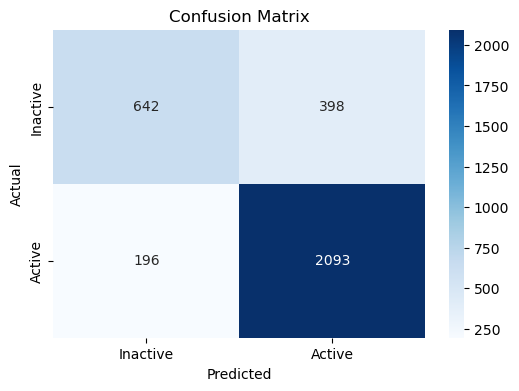

In [69]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Inactive", "Active"], yticklabels=["Inactive", "Active"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [77]:
import joblib

joblib.dump(clf, "data/processed/egfr_model.pkl")
print("✅ model saved.")

✅ model saved.


In [75]:
clf_loaded = joblib.load("data/processed/egfr_model.pkl")

In [83]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, Crippen

def calc_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    descriptors = [
        Descriptors.MolWt(mol),
        Crippen.MolLogP(mol),
        Lipinski.NumHDonors(mol),
        Lipinski.NumHAcceptors(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumRotatableBonds(mol),
        Chem.rdMolDescriptors.CalcNumRings(mol)
    ]
    return descriptors

smiles = "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O"
features = calc_descriptors(smiles)

if features is None:
    print("Invalid SMILES string.")
else:
    feature_names = ['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'NumRotatableBonds', 'RingCount']
    features_df = pd.DataFrame([features], columns=feature_names)
    prediction = clf_loaded.predict(features_df)[0]
    label = "Active" if prediction == 1 else "Inactive"
    print(f"Prediction result: {label}")


Prediction result: Inactive


In [87]:
smiles_list = [
    "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",         #inactive
    "CCOC(=O)C1=CC=CC=C1",                   # 1
    "CCN(CC)CCOC(=O)C1=CC=CC=C1",            # 2
    "CC1=CC=CC=C1C(=O)NC2=CC=CC=C2",         # 3
    "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",          # 4
]

for smiles in smiles_list:
    features = calc_descriptors(smiles)
    if features is None:
        print(f"SMILES {smiles} is invalid.")
        continue
    
    features_df = pd.DataFrame([features], columns=[
        'MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'NumRotatableBonds', 'RingCount' ])
    
    prediction = clf_loaded.predict(features_df)[0]
    label = "Active" if prediction == 1 else "Inactive"
    print(f"SMILES: {smiles}  →  Prediction: {label}")

SMILES: CC(C)CC1=CC=C(C=C1)C(C)C(=O)O  →  Prediction: Inactive
SMILES: CCOC(=O)C1=CC=CC=C1  →  Prediction: Inactive
SMILES: CCN(CC)CCOC(=O)C1=CC=CC=C1  →  Prediction: Inactive
SMILES: CC1=CC=CC=C1C(=O)NC2=CC=CC=C2  →  Prediction: Inactive
SMILES: CN1C=NC2=C1C(=O)N(C(=O)N2C)C  →  Prediction: Inactive
